## Image Classifier

### Project Overview
* Produced an Image Classification model for detecting if the person in an image is male or female using a Convolutional Neural Network Model and Transfer Learning, obtaining 97% accuracy. 
* Implemented Transfer Learning using Inception-v3, optimized with learning rate schedulers.
* Directories design and images loading.
* Analized models errors.

### Code and Resources Used 
**Python Version:** 3.7  
**Packages:** pandas, numpy, matplotlib, seaborn, plotly, sklearn, tensorflow, keras.

### Dataset
Was developed by Hong Kong University Multimedia Laboratory and originally has 202599 images of celebrities faces and 40 binary attributes annotations per image in a different folder.  
A balanced smaller set with 40000 images was made for computing power and time execution reasons, with the gender attribute as label.

Dataset: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

<!-- ![](images/capture_1.PNG)
![](images/capture_2.PNG)
![](images/capture_3.PNG) -->

### Data preparation
Images were assigned to its corresponding gender attribute and directories were created to divide the images by gender and then in train/test sets.
With the images loaded in an organized folder structure, data was prepared for the models training using ImageDataGenerator of the keras preprocessing module.

### Models Building and Performance
Two models were trained: a baseline CNN model with its learning rate tuned with the use of an scheduler and RMSprop optimizers, and a second CNN using the Inception v3 architecture loaded with weights pre-trained on ImageNet, also tuned with a scheduler.

* **CNN**: Accuracy=0.96.
* **CNN-Inception**: Accuracy=0.97.

### Metrics Chosen
**Accuracy** was considered a reliable metric  given that we had a perfectly balanced dataset.

### Notebook content

1. Data and libraries loading
2. Exploratory Data Analysis
3. Data Preparation
4. Models Training, Evaluation and Error Analysis
5. Conclusion




### 1. Data and libraries loading

---

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download 'jessicali9530/celeba-dataset'

100% 1.32G/1.33G [00:09<00:00, 159MB/s]
100% 1.33G/1.33G [00:09<00:00, 152MB/s]


In [ ]:
! unzip 'celeba-dataset.zip'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
from keras.utils import load_img

In [9]:
import os
import cv2
import shutil
from shutil import copyfile

### 2. Exploratory Data Analysis
___

Dataset content:  
**• Overall**  
- 202,599 face images.  
- 10,177 unique identities.  
- 40 binary attribute annotations per image.  
- 5 landmark locations.  

**• Data Files**  
- imgalignceleba.zip: All the face images, cropped and aligned.  
- listevalpartition.csv: Recommended partitioning of images into training, validation, testing sets. 
- listbboxceleba.csv: Bounding box information for each image. 
- listlandmarksalign_celeba.csv: Image landmarks and their respective coordinates. 
- listattrceleba.csv: Attribute labels for each image. 

Dataset folders inspection:

• list_attr_celeba.csv: Attribute labels for each image.

In [10]:
df_attr = pd.read_csv('list_attr_celeba.csv')

In [ ]:
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


There are 40 attributes. "1" represents positive, "-1" represents negative. The 'Male' attribute will be our target column.

• imgalignceleba.zip: All the face images, cropped and aligned.

In [22]:
imgs_path = 'img_align_celeba/img_align_celeba/'
file_example = imgs_path + '000068.jpg'
img_example = load_img(file_example)

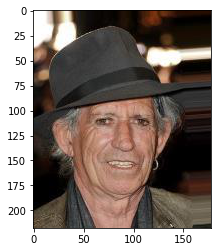

In [ ]:
plt.imshow(img_example)
plt.show()

Let's check the example image attributes

In [ ]:
df_attr.loc[67]

image_id               000068.jpg
5_o_Clock_Shadow               -1
Arched_Eyebrows                -1
Attractive                     -1
Bags_Under_Eyes                 1
Bald                           -1
Bangs                          -1
Big_Lips                       -1
Big_Nose                        1
Black_Hair                     -1
Blond_Hair                     -1
Blurry                         -1
Brown_Hair                     -1
Bushy_Eyebrows                 -1
Chubby                         -1
Double_Chin                    -1
Eyeglasses                     -1
Goatee                         -1
Gray_Hair                      -1
Heavy_Makeup                   -1
High_Cheekbones                 1
Male                            1
Mouth_Slightly_Open             1
Mustache                       -1
Narrow_Eyes                    -1
No_Beard                        1
Oval_Face                      -1
Pale_Skin                      -1
Pointy_Nose                    -1
Receding_Hairl

Data is correct, given that Richads is a man, has bags under his eyes, has no beard, is smiling and wearing a hat.

Our target for this particular image:

In [ ]:
df_attr['Male'][67]

1

Images shape:

In [ ]:
img_example_ = cv2.imread(file_example)

In [ ]:
img_example_.shape

(218, 178, 3)

In [ ]:
print('width: {}'.format(img_example_.shape[1]))
print('height: {}'.format(img_example_.shape[0]))
print('channels: {}'.format(img_example_.shape[2]))

width: 178
height: 218
channels: 3


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


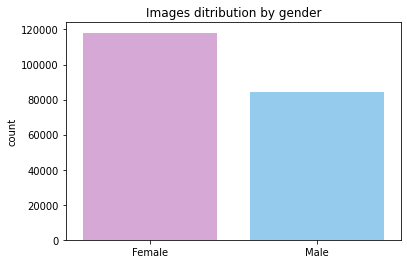

In [ ]:
plt.title('Images ditribution by gender')
cp = sns.countplot(df_attr['Male'], palette=['plum','lightskyblue'])
cp.set_xticklabels(labels = ['Female', 'Male'])
plt.xlabel('')

plt.show()


In [ ]:
print('Female picures:', len(df_attr[df_attr['Male']==-1]))
print('Male picures:', len(df_attr[df_attr['Male']==1]))

Female picures: 118165
Male picures: 84434


The dataset is unbalance with respect to gender.

### 3. Data preparation

---


• Data directories map:


 
                |-> male (A)                     | -> training |-> male (C) 
    gdr_cv_data |              ===>  gdr_cv_pics |             |
                |-> female (B)                   |             |-> female (D) 
                                                 |
                                                 | -> testing  |-> male (E) 
                                                               |  
                                                               |-> female (F)  
                                                                  
    A loads C and E, B loads D and F

• Directories creation

We start creating a first main directory divided in two class (male/female) subidirectories where all the images will be loaded:

In [11]:
os.mkdir('gdr_cv_data/')
os.mkdir('gdr_cv_data/male/')
os.mkdir('gdr_cv_data/female/')

We create a second new directory that will be divided in training and testing subdirectories, which in turn will be divided in class subdirectories:

In [12]:
os.mkdir('gdr_cv_pics/')
root_dir = 'gdr_cv_pics/'

Function for creating the class divided Train and Test subdirectories:

In [13]:
def create_train_test_dirs(root_path):
    train_test = ['training/', 'testing/']
    classes = ['male/', 'female/']
    for i in train_test:
        os.mkdir(os.path.join(root_path, i))
        path = root_path + i 
        for j in classes:
            os.mkdir(os.path.join(path, j))

In [14]:
create_train_test_dirs(root_path=root_dir)

Directories for 'Male/Female' class data and for the 'Train/Test' split are ready.

• Directories loading

We create a dataframe that will contain the information we need to direct our data to the corresponding directory:

In [15]:
df_ = df_attr.copy()

In [16]:
df_ = df_[['image_id', 'Male']]

In [17]:
df_.set_index('image_id', inplace=True)

In [18]:
df_.head(1)

,Male
image_id,
000001.jpg,-1


First we divide our data in folders according to its Male/Female class (information given by our df_ dataframe):

In [23]:
SOURCE = imgs_path
MALE = 'gdr_cv_data/male/'
FEMALE = 'gdr_cv_data/female/'
DF = df_

Function for loading the first directories:

In [20]:
def data_prep(SOURCE, MALE, FEMALE): 
    
    for file in os.listdir(SOURCE):
        if (DF.loc[file]['Male']==1):
            copyfile(SOURCE + file, MALE + file)
        else:
            copyfile(SOURCE + file, FEMALE + file) 

We load the directories with the according data:  

In [24]:
data_prep(SOURCE, MALE, FEMALE)

Folders sanity check:

In [25]:
print(len(os.listdir(MALE)))
print(len(os.listdir(FEMALE)))

84434
118165


Now we load the second directories, spliting our classified data in training and testing folders:

In [26]:
MALE_SOURCE_DIR = 'gdr_cv_data/male/'
TRAINING_MALE_DIR = 'gdr_cv_pics/training/male/'
TESTING_MALE_DIR = 'gdr_cv_pics/testing/male/'

FEMALE_SOURCE_DIR = 'gdr_cv_data/female/'
TRAINING_FEMALE_DIR = 'gdr_cv_pics/training/female/'
TESTING_FEMALE_DIR = 'gdr_cv_pics/testing/female/'

We will use only 20000 images of each class due to time execution:

In [27]:
SPLIT_SIZE = .9
LIMIT_SIZE = 20000 

Function for loading classified data into Train and Testing sets:

In [28]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE, LIMIT_SIZE): 

    files = []
    
    counter = 0
    limit = LIMIT_SIZE

    for file in (os.listdir(SOURCE)):
        if counter < limit:
            files.append(file)
            counter += 1

    size = int(len(files))
    split = int(size * SPLIT_SIZE)
    
    train_set = files[:split]
    test_set = files[split:]
    
    for file in train_set:
        copyfile(SOURCE + file, TRAINING + file)
        
    for file in test_set:
        copyfile(SOURCE + file, TESTING + file)

Train and Test folders loading:

In [29]:
split_data(MALE_SOURCE_DIR, TRAINING_MALE_DIR, TESTING_MALE_DIR, SPLIT_SIZE, LIMIT_SIZE)

In [30]:
split_data(FEMALE_SOURCE_DIR, TRAINING_FEMALE_DIR, TESTING_FEMALE_DIR, SPLIT_SIZE, LIMIT_SIZE)

In [31]:
print('Training Male Dir Size: ', len(os.listdir(TRAINING_MALE_DIR)))
print('Testing Male Dir Size: ', len(os.listdir(TESTING_MALE_DIR)))
print('Training Female Dir Size: ', len(os.listdir(TRAINING_FEMALE_DIR)))
print('Testing Female Dir Size: ', len(os.listdir(TESTING_FEMALE_DIR)))

Training Male Dir Size:  18000
Testing Male Dir Size:  2000
Training Female Dir Size:  18000
Testing Female Dir Size:  2000


We have a reduced balanced dataset divided in Train/Test and Binary Class label subdirectories.

• Data preparation for the Models:

In [32]:
TRAINING_DIR = 'gdr_cv_pics/training/'
train_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                               batch_size=100,
                               class_mode='binary',
                               target_size=(218, 178))

VALIDATION_DIR = 'gdr_cv_pics/testing/'
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                         batch_size=100,
                                         class_mode='binary',
                                         target_size=(218, 178))

Found 36000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


### 4. Models Training, Evaluation and Error Analysis
---

Model results plotting function:

In [33]:
def res_plot(param_train, param_test, param):
    plt.plot(epochs, param_train)
    plt.plot(epochs, param_test)
    plt.title(f'Training and Test {param} per epoch')
    plt.xlabel(f'epoch')
    plt.ylabel(f'{param}')
    plt.show()

Model prediction and visualization function: 

In [34]:
def model_gender_prediction(filename, MODEL):

    imgs_path = 'img_align_celeba/img_align_celeba/'
    file_ = imgs_path + filename
   
    im = cv2.imread(file_)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0    
    im = np.expand_dims(im, axis =0)
    
    result = MODEL.predict(im)
    prediction = np.argmax(result)

    img_pic = load_img(file_)

    if result[0]>0.5:
        print(filename + " is male")
    else:
        print(filename + " is female")
    
    return img_pic

#### Model 1: CNN 

Model Learning rate optimization:

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(218, 178, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9)

In [ ]:
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model_cnn.fit_generator(train_generator,
                                  epochs=20,
                                  verbose=1,
                                  validation_data=validation_generator,
                                  callbacks=[lr_scheduler])

<ipython-input-46-0137dc55b2d9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_cnn.fit_generator(train_generator,


Epoch 1/20
360/360 [==============================] - 98s 264ms/step - loss: 0.2841 - acc: 0.8726 - val_loss: 0.1380 - val_acc: 0.9510 - lr: 1.0000e-04
Epoch 2/20
360/360 [==============================] - 91s 254ms/step - loss: 0.1260 - acc: 0.9523 - val_loss: 0.1076 - val_acc: 0.9555 - lr: 1.1220e-04
Epoch 3/20
360/360 [==============================] - 92s 256ms/step - loss: 0.0932 - acc: 0.9647 - val_loss: 0.1036 - val_acc: 0.9645 - lr: 1.2589e-04
Epoch 4/20
360/360 [==============================] - 93s 259ms/step - loss: 0.0800 - acc: 0.9695 - val_loss: 0.1104 - val_acc: 0.9585 - lr: 1.4125e-04
Epoch 5/20
360/360 [==============================] - 93s 259ms/step - loss: 0.0653 - acc: 0.9749 - val_loss: 0.0967 - val_acc: 0.9635 - lr: 1.5849e-04
Epoch 6/20
360/360 [==============================] - 91s 253ms/step - loss: 0.0560 - acc: 0.9782 - val_loss: 0.1105 - val_acc: 0.9607 - lr: 1.7783e-04
Epoch 7/20
360/360 [==============================] - 92s 257ms/step - loss: 0.0490 - ac

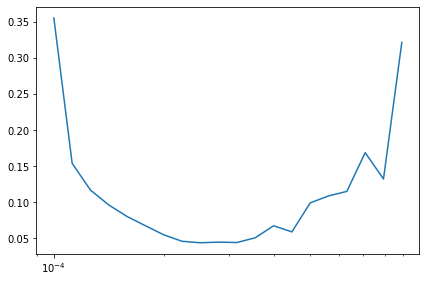

In [ ]:
lrs = 1e-4 * (10 ** (np.arange(20) / 20))
# plt.figure(figsize=(10,5))
# plt.xticks(rotation=45)
plt.semilogx(lrs, history.history["loss"])
plt.tight_layout(True)
plt.show()

In [ ]:
lrs 

array([0.0001    , 0.0001122 , 0.00012589, 0.00014125, 0.00015849,
       0.00017783, 0.00019953, 0.00022387, 0.00025119, 0.00028184,
       0.00031623, 0.00035481, 0.00039811, 0.00044668, 0.00050119,
       0.00056234, 0.00063096, 0.00070795, 0.00079433, 0.00089125])

In [ ]:
min_loss=np.min(history.history['loss'])
index=np.argmin(history.history['loss'])

In [ ]:
print(f'Minimun loss: {min_loss}')
print(f'lr: {lrs[index]}')

Minimun loss: 0.041792117059230804
lr: 0.00022387211385683394


Model re-traininig 

In [ ]:
tf.keras.backend.clear_session()

In [35]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(218, 178, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [36]:
model_cnn.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])     


In [37]:
history = model_cnn.fit_generator(train_generator,               
                                  epochs=20,
                                  verbose=1,
                                  validation_data=validation_generator)

<ipython-input-37-a4111e497c69>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_cnn.fit_generator(train_generator,                # -> for epochs=20, learning_rate=0.0001, 20000 fotos


Epoch 1/20
360/360 [==============================] - 117s 286ms/step - loss: 0.5101 - acc: 0.7417 - val_loss: 0.3565 - val_acc: 0.8525
Epoch 2/20
360/360 [==============================] - 93s 258ms/step - loss: 0.2770 - acc: 0.8896 - val_loss: 0.1930 - val_acc: 0.9268
Epoch 3/20
360/360 [==============================] - 108s 300ms/step - loss: 0.1845 - acc: 0.9301 - val_loss: 0.1586 - val_acc: 0.9350
Epoch 4/20
360/360 [==============================] - 103s 287ms/step - loss: 0.1482 - acc: 0.9442 - val_loss: 0.1514 - val_acc: 0.9383
Epoch 5/20
360/360 [==============================] - 94s 261ms/step - loss: 0.1255 - acc: 0.9531 - val_loss: 0.1396 - val_acc: 0.9473
Epoch 6/20
360/360 [==============================] - 90s 251ms/step - loss: 0.1071 - acc: 0.9601 - val_loss: 0.1153 - val_acc: 0.9520
Epoch 7/20
360/360 [==============================] - 90s 250ms/step - loss: 0.0927 - acc: 0.9650 - val_loss: 0.1110 - val_acc: 0.9542
Epoch 8/20
360/360 [==============================] 

Collecting results:

In [38]:
acc = model_cnn.history.history['acc']
val_acc = model_cnn.history.history['val_acc']
loss = model_cnn.history.history['loss']
val_loss = model_cnn.history.history['val_loss']
epochs = range(len(acc)) 

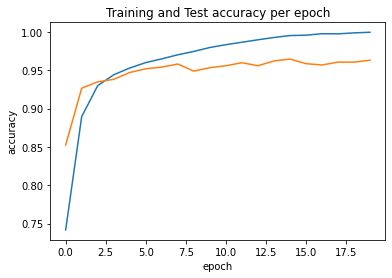

In [39]:
res_plot(acc, val_acc, 'accuracy')                 

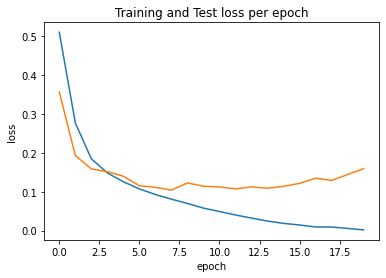

In [40]:
res_plot(loss, val_loss, 'loss')

In [48]:
print(f'Accuracy in Test Set: {val_acc[-1]:.2}')

Accuracy in Test Set: 0.96


Our model reaches 96% accuracy in the test set.

#### Model results visualization

Model testing with files from the test set:

1/1 [==============================] - 0s 16ms/step
194500.jpg is female


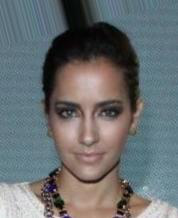

In [ ]:
model_gender_prediction('194500.jpg', model_cnn)

1/1 [==============================] - 0s 18ms/step
001986.jpg is male


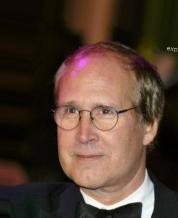

In [ ]:
model_gender_prediction('001986.jpg', model_cnn)

#### Model 2: Inception 

In [54]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

We start downloading the pretrained weights and setting them to a variable:

In [55]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-03-28 21:29:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 142.251.163.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/inception_v3_weigh 100%[===================>]  83.84M   104MB/s    in 0.8s    

2023-03-28 21:29:14 (104 MB/s) - ‘/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [56]:
local_weights_file = '/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

We initialize the base model (removing the dense layers), load the pre-trained weights and freeze the weights of the layers:

In [57]:
pre_trained_model = InceptionV3(input_shape = (218, 178, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 108, 88, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 108, 88, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [58]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 11, 9, 768)


We will add at the end of our model:  
- a fully connected layer with 1,024 hidden units and ReLU activation,  
- a dropout rate of 0.2,   
- a final sigmoid layer for classification:

In [59]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           
model_inc = Model(pre_trained_model.input, x) 

model_inc.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 178, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 108, 88, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 108, 88, 32)  96         ['conv2d_3[0][0]']               
 alization)                                                                                       
                                                                                              

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9)

In [ ]:
model_inc.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model_inc.fit_generator(train_generator,
                                  epochs=20,
                                  verbose=1,
                                  validation_data=validation_generator,
                                  callbacks=[lr_scheduler])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
180/180 [==============================] - 52s 222ms/step - loss: 0.3609 - acc: 0.9092 - val_loss: 0.1299 - val_acc: 0.9535 - lr: 1.0000e-04
Epoch 2/20
180/180 [==============================] - 41s 228ms/step - loss: 0.0995 - acc: 0.9617 - val_loss: 0.2043 - val_acc: 0.9270 - lr: 1.1220e-04
Epoch 3/20
180/180 [==============================] - 39s 215ms/step - loss: 0.0671 - acc: 0.9743 - val_loss: 0.1312 - val_acc: 0.9600 - lr: 1.2589e-04
Epoch 4/20
180/180 [==============================] - 37s 203ms/step - loss: 0.0517 - acc: 0.9821 - val_loss: 0.1705 - val_acc: 0.9570 - lr: 1.4125e-04
Epoch 5/20
180/180 [==============================] - 36s 199ms/step - loss: 0.0496 - acc: 0.9837 - val_loss: 0.2163 - val_acc: 0.9475 - lr: 1.5849e-04
Epoch 6/20
180/180 [==============================] - 36s 200ms/step - loss: 0.0373 - acc: 0.9861 - val_loss: 0.1731 - val_acc: 0.9595 - lr: 1.7783e-04
Epoch 7/20
180/180 [==============================] - 36s 198ms/step - loss: 0.0426 - ac

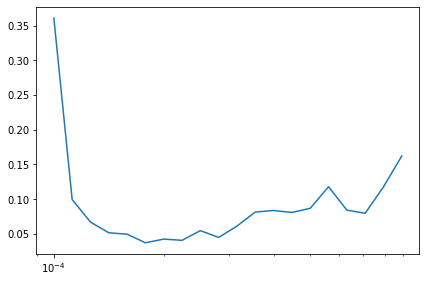

In [ ]:
lrs = 1e-4 * (10 ** (np.arange(20) / 20))

plt.semilogx(lrs, history.history["loss"])
plt.tight_layout(True)
plt.show()

In [ ]:
lrs 

array([0.0001    , 0.0001122 , 0.00012589, 0.00014125, 0.00015849,
       0.00017783, 0.00019953, 0.00022387, 0.00025119, 0.00028184,
       0.00031623, 0.00035481, 0.00039811, 0.00044668, 0.00050119,
       0.00056234, 0.00063096, 0.00070795, 0.00079433, 0.00089125])

In [ ]:
min_loss=np.min(history.history['loss'])
index=np.argmin(history.history['loss'])

In [ ]:
print(f'Minimun loss: {min_loss}')
print(f'lr: {lrs[index]}')

Minimun loss: 0.03730704262852669
lr: 0.0001778279410038923


Model re-traininig:

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           
model_inc = Model(pre_trained_model.input, x) 

In [61]:
model_inc.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [62]:
history = model_inc.fit_generator(train_generator,
                             validation_data=validation_generator,
                             epochs=20,
                             )

<ipython-input-62-b3411620d6c0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_inc.fit_generator(train_generator,


Epoch 1/20
360/360 [==============================] - 107s 283ms/step - loss: 0.2118 - accuracy: 0.9190 - val_loss: 0.1065 - val_accuracy: 0.9585
Epoch 2/20
360/360 [==============================] - 98s 271ms/step - loss: 0.1040 - accuracy: 0.9596 - val_loss: 0.0883 - val_accuracy: 0.9660
Epoch 3/20
360/360 [==============================] - 101s 279ms/step - loss: 0.0732 - accuracy: 0.9725 - val_loss: 0.1803 - val_accuracy: 0.9293
Epoch 4/20
360/360 [==============================] - 99s 275ms/step - loss: 0.0529 - accuracy: 0.9812 - val_loss: 0.1082 - val_accuracy: 0.9600
Epoch 5/20
360/360 [==============================] - 100s 276ms/step - loss: 0.0425 - accuracy: 0.9846 - val_loss: 0.3864 - val_accuracy: 0.8783
Epoch 6/20
360/360 [==============================] - 96s 267ms/step - loss: 0.0307 - accuracy: 0.9899 - val_loss: 0.0914 - val_accuracy: 0.9672
Epoch 7/20
360/360 [==============================] - 97s 270ms/step - loss: 0.0242 - accuracy: 0.9927 - val_loss: 0.0912 - val

Collecting results:

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

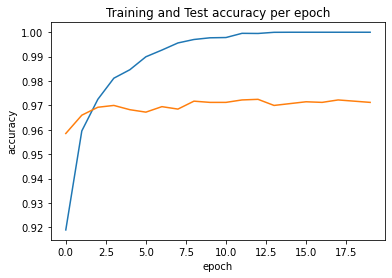

In [68]:
res_plot(acc, val_acc, 'accuracy')

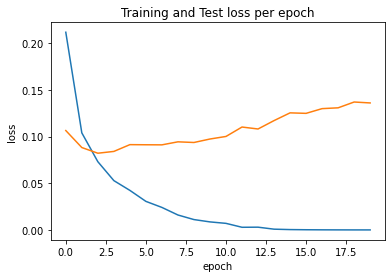

In [112]:
res_plot(loss, val_loss, 'loss')

In [70]:
print(f'Accuracy in Test Set: {val_acc[-1]:.2}')

Accuracy in Test Set: 0.97


Our Transfer Learning model reaches 97% accuracy in the test set.

#### Model results visualization

1/1 [==============================] - 0s 29ms/step
001986.jpg is male


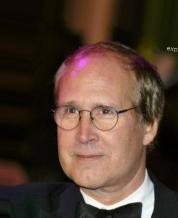

In [73]:
model_gender_prediction('001986.jpg', model_inc)

1/1 [==============================] - 1s 1s/step
194500.jpg is female


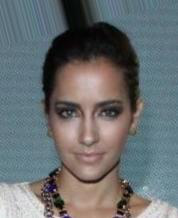

In [72]:
model_gender_prediction('194500.jpg', model_inc)

1/1 [==============================] - 0s 41ms/step
001980.jpg is male


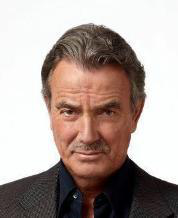

In [75]:
model_gender_prediction('001980.jpg', model_inc)

1/1 [==============================] - 0s 120ms/step
177408.jpg is female


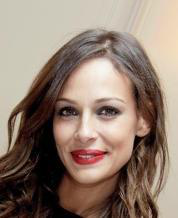

In [87]:
model_gender_prediction('177408.jpg', model_inc)

1/1 [==============================] - 0s 52ms/step
137489.jpg is male


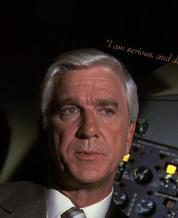

In [105]:
model_gender_prediction('137489.jpg', model_inc)

1/1 [==============================] - 0s 28ms/step
199926.jpg is female


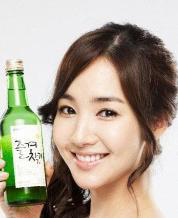

In [113]:
model_gender_prediction('199926.jpg', model_inc)

### 5. Conclusion

After creating a reduced and balanced dataset for training our models and tuning them using learning rate schedulers both the CNN and the Inception based model obtained optimal results on the test set. Our Transfer Learning model in which we used the Inception v3 architecture with pretrained weights had the best results with 97% Accuracy.
This model error evolution curves showed signs of overfitting what will be tested and tried to improve in future trainings of the model with a bigger train set.